In [1]:
import cv2
import sys
from matplotlib import pyplot as plt 
import numpy as np
import sklearn
from collections import deque

print(cv2.__version__)
print(np.__version__)
print(sklearn.__version__)

4.4.0
1.17.2
0.23.2


In [2]:
grayFakeFaceC = cv2.cvtColor(cv2.imread("./test/fake_center.png"), cv2.COLOR_BGR2GRAY)
grayFakeFaceL = cv2.cvtColor(cv2.imread("./test/fake_left.png"), cv2.COLOR_BGR2GRAY)
grayFakeFaceR = cv2.cvtColor(cv2.imread("./test/fake_right.png"), cv2.COLOR_BGR2GRAY)

fakeFace = [grayFakeFaceC, grayFakeFaceL, grayFakeFaceR]

grayRealFaceC = cv2.cvtColor(cv2.imread("./test/real_center.png"), cv2.COLOR_BGR2GRAY)
grayRealFaceL = cv2.cvtColor(cv2.imread("./test/real_left.png"), cv2.COLOR_BGR2GRAY)
grayRealFaceR = cv2.cvtColor(cv2.imread("./test/real_right.png"), cv2.COLOR_BGR2GRAY)

fakeFace = [grayFakeFaceC, grayFakeFaceL, grayFakeFaceR]

In [3]:
# def resize(img1, img2):
#     print(img1.shape[:2], img2.shape[:2])
#     minX = min(img1.shape[0], img2.shape[0])
#     minY = min(img1.shape[1], img2.shape[1])
#     resizedImg1 = cv2.resize(img1, (minX, minY), interpolation = cv2.INTER_AREA)
#     resizedImg2 = cv2.resize(img2, (minX, minY), interpolation = cv2.INTER_AREA)
#     return resizedImg1, resizedImg2

def matches(img1, img2):   
    my_SIFT_instance = cv2.SIFT_create()
    kp1, des1 = my_SIFT_instance.detectAndCompute(img1,None)
    kp2, des2 = my_SIFT_instance.detectAndCompute(img2,None)
    lowes = cv2.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks=50)).knnMatch(des1,des2,k=2)
    
    leftPoints, rightPoints = [], []
    for m, n in lowes:  
        if (m.distance/n.distance) < 0.8:
            rightPoints.append(kp2[m.trainIdx].pt)
            leftPoints.append(kp1[m.queryIdx].pt)
            
    leftPoints, rightPoints = np.int32(leftPoints), np.int32(rightPoints)
    fundMatrix, mask = cv2.findFundamentalMat(leftPoints, rightPoints, cv2.FM_RANSAC)
    print(len(leftPoints),len(rightPoints))
    width, height = img1.shape[:2]
    success ,homo1, homo2 = cv2.stereoRectifyUncalibrated(leftPoints, rightPoints, fundMatrix, img1.shape[:2])

    imgMatch1 = cv2.warpPerspective(img1, homo1, (height, width))
    imgMatch2 = cv2.warpPerspective(img2, homo2, (height, width))
    
    return imgMatch1, imgMatch2

213 213
20 20


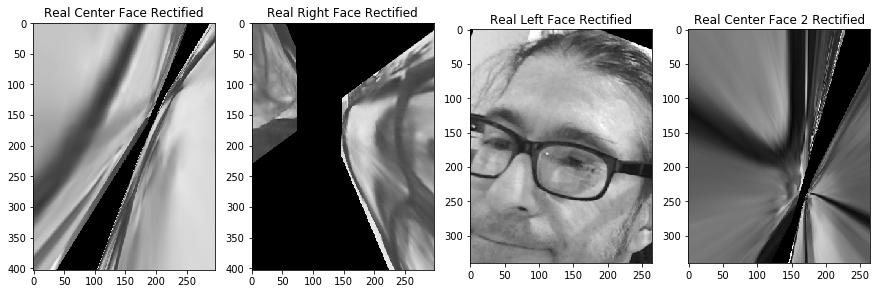

In [4]:
# realLeftMatch, realRightMatch = matches(grayRealFaceL, grayRealFaceR)

# plt.figure(figsize=(15,15))
# plt.subplot(1, 2, 1)
# plt.title("Left Tape Rectified")
# plt.imshow(realLeftMatch, cmap = 'gray')
# plt.subplot(1, 2, 2)
# plt.title("Left Coasters Rectified")
# plt.imshow(realRightMatch, cmap = 'gray')

# resized1, resized2 = resize(grayRealFaceL, grayRealFaceR)
realCenMatch, realRightMatch = matches(grayFakeFaceC, grayFakeFaceL)
realCen2Match, realLeftMatch = matches(grayRealFaceR, grayRealFaceL)


plt.figure(figsize=(15,15))
plt.subplot(1, 4, 1)
plt.title("Real Center Face Rectified")
plt.imshow(realCenMatch, cmap = 'gray')
plt.subplot(1, 4, 2)
plt.title("Real Right Face Rectified")
plt.imshow(realRightMatch, cmap = 'gray')
plt.subplot(1, 4, 3)
plt.title("Real Left Face Rectified")
plt.imshow(realLeftMatch, cmap = 'gray')
plt.subplot(1, 4, 4)
plt.title("Real Center Face 2 Rectified")
plt.imshow(realCen2Match, cmap = 'gray')
